In [1]:
# imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import operator, os

### Utilities

In [2]:
def show_image(img, title = ''):
    plt.imshow(img, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
def draw_external_grid(img, squares, line_size): # draw external grid shape
    cv2.line(img, tuple(corners[0]), tuple(corners[1]), (154,205,50), line_size)
    cv2.line(img, tuple(corners[1]), tuple(corners[2]), (154,205,50), line_size)
    cv2.line(img, tuple(corners[2]), tuple(corners[3]), (154,205,50), line_size)
    cv2.line(img, tuple(corners[3]), tuple(corners[0]), (154,205,50), line_size)
    show_image(img, 'Tris to extract')

In [4]:
def euclidean_distance(p1, p2): # Returns the euclidean distance between two points
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [5]:
def cut_img(img, cell): # given an image, cuts a rectangle using the top left and bottom right points
    return img[int(cell[0][1]):int(cell[1][1]), int(cell[0][0]):int(cell[1][0])]

### 0. Load Image

In [6]:
def load_img(path, file_name):
    try:
        grey_scale_img = cv2.imread(path + file_name, cv2.IMREAD_GRAYSCALE)
        #show_image(grey_scale_img) # check if the image has been correctly loaded
    except:
        print("Image not loaded, please check path name!")
    return grey_scale_img

### 1. Image pre-processing

In [7]:
def img_pre_processing(img, kernel_size):
    # Using a blurring function, adaptive thresholding to expose the main features of an image.
    processed_img = cv2.GaussianBlur(img.copy(), (kernel_size, kernel_size), 0)
    processed_img = cv2.adaptiveThreshold(processed_img, 
                                            255, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV,
                                            57,
                                            5)
    show_image(processed_img, 'Processed Image')
    return processed_img

### 2. Find Grid

In [8]:
def find_contours(img): # find the largest structure 
    # contours contour retrieval mode, hierarchy is contour approximation method
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key= cv2.contourArea, reverse = True)  # sort by area, descending
    largest_contour = contours[0]  # largest contour

    
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in largest_contour]), 
                        key = operator.itemgetter(1))
    top_left, _     = min(enumerate([pt[0][0] + pt[0][1] for pt in largest_contour]), 
                        key = operator.itemgetter(1))
    bottom_left, _  = min(enumerate([pt[0][0] - pt[0][1] for pt in largest_contour]), 
                        key = operator.itemgetter(1))
    top_right, _    = max(enumerate([pt[0][0] - pt[0][1] for pt in largest_contour]), 
                        key = operator.itemgetter(1))
    # return an array of all 4 corner points 
    return [largest_contour[top_left][0], 
            largest_contour[top_right][0], 
            largest_contour[bottom_right][0], 
            largest_contour[bottom_left][0]]

#### 2.1 Warp Image

In [9]:
def warp_img(img, corners): # warps a rectangular section from an image into a square of similar size
                            # helps make following process easier
    top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[2], corners[3]

    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype = 'float32') # casting otherwise error

    # fet the longest side in the rectangle
    side = max([
        euclidean_distance(bottom_right, top_right),
        euclidean_distance(top_left, bottom_left),
        euclidean_distance(bottom_right, bottom_left),
        euclidean_distance(top_left, top_right)])

    # define the destination square
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype = 'float32')

    m = cv2.getPerspectiveTransform(src, dst)

    # ferforms the transformation on the original image
    warpped_img = cv2.warpPerspective(img, m, (int(side), int(side)))
    show_image(warpped_img, 'Warpped tris')
    
    return warpped_img

### 3. Get Symbols

#### 3.1 Get Cells

In [10]:
def get_cells_sizes(img, d_grid = 3): # tris has 9 cells
                                      # d_grid = X for other grid games (e.g. sudoku d_grid = 9)
    cells = []
    side = img.shape[:1] # uses warpped image
    side = side[0] / d_grid

    for j in range(d_grid):
        for i in range(d_grid):
            p1 = (i * side, j * side)  # top-left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # bottom-right corner of bounding box
            cells.append((p1, p2))
    return cells

In [11]:
def get_symbols(img, cells, kernel_size, model): # extracts symbols from their cells and builds an array with detected symbols
    symbols = [] 
    processed_img = img_pre_processing(img.copy(), kernel_size)
    
    # helps neural network to have far better results
    processed_img = cv2.bitwise_not(processed_img, processed_img)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    processed_img = cv2.dilate(processed_img, kernel)
        
    temp = cv2.cvtColor(processed_img.copy(), cv2.COLOR_GRAY2BGR)
    
    i = 0
    for cell in cells:
        symbols.append(extract_symbols(processed_img, cell, str(i), model))
        a, b = (int(cell[0][0]),int(cell[0][1])), (int(cell[1][0]),int(cell[1][1]))
        cv2.rectangle(temp, a, b, (0,255,0), 20)
        i += 1
    show_image(temp, 'Symbols to extract withing cells') # not needed 
    return symbols
    

#### 3.2 Extract Symbols
For each cell, predict and return the value inside

In [12]:
def extract_symbols(img, cell, name, model):
    symbol = cut_img(img, cell)  # get cell from given the input img
    #show_image(symbol) # check how the cell looks like
    
    # reshaping to focus on centered objects 
    cell_size = symbol.shape[0]
    new_size = int(cell_size - 15 * cell_size/100)
    symbol = symbol[:new_size, :new_size]
    
    # temporary saving the file to allow tensorflow interaction
    file_name = "temp/" + name + '.jpg'
    cv2.imwrite(file_name, symbol)
    

    img = tf.keras.utils.load_img(
    file_name, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch



    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    os.remove(file_name)

    return class_names[np.argmax(score)] # return the class name with higher prediction score

### 4. Model Creation

In [13]:
# imports

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
def create_model():
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    return model

### 5. Solve Tris

In [15]:
import tris
def solve(symbols):
    tris.load_board(symbols)

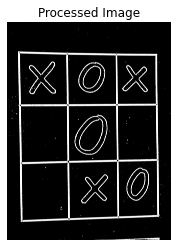

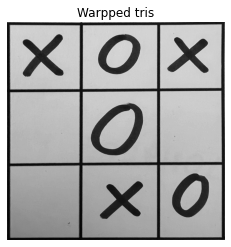

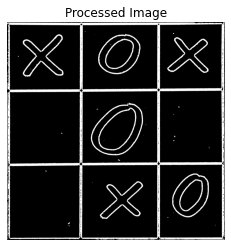

2022-02-10 12:00:38.306415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


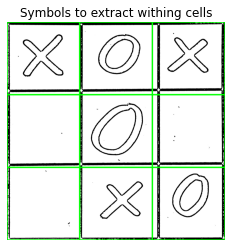

['X', 'O', 'X', 'empty', 'O', 'empty', 'empty', 'X', 'O']
{1: 'X', 2: 'O', 3: 'X', 4: 'X', 5: 'O', 6: ' ', 7: ' ', 8: 'X', 9: 'O'}
(4, 3)
O moves in 6
 X | O | X
---+---+---
 X | O | O
---+---+---
   | X | O





In [17]:
# main

path = 'img/'
file_name = 'mode_test.jpg'
kernel_size = 11 # high kernel_size since only need to focus on large stracture
img_height = 180
img_width = 180
class_names = ['O','X', 'empty']
num_classes = len(class_names)


grey_scale_img = load_img(path, file_name)
processed_img = img_pre_processing(grey_scale_img, kernel_size)
corners = find_contours(processed_img)

wrapped_img = warp_img(grey_scale_img, corners) # uses information from the processed img
cells = get_cells_sizes(wrapped_img)
# load model
model = create_model()
if 'weights.h5' in os.listdir('model/'):
    model.load_weights('model/weights.h5')
else:
    %run model_creation.ipynb


symbols = get_symbols(wrapped_img, cells, 21, model) # larger kernel_size allow to deeply denoise the image
print(symbols)
solve(symbols)